In [3]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## Constants 
hbar = 1.05*(10**(-34))
pi = 3.14159 
c = 3*(10**(8))
kb = 8.617*(10**(-5))
kb_SI = 1.38*(10**(-23))
qe = 1.6*(10**(-19)) 
eps0 = 8.85*(10**(-12))  
m0 = 9*(10**(-31)) 
to_ang = 10**(-10)
a_lat = 3.1*(10**(-10)) 

In [43]:
def get_fermi_circle(k_rad, nk, nthet): 
    ##Input: radius of 2D Fermi circle (float)[m**(-1)], size of k array (int), size of theta array (int)
    ##Output: grid of k points in Fermi circle [m**(-1)] 
    kx_list = []
    ky_list = []
    k_range = np.linspace(0 ,k_rad, int(nk))
    thet_range = np.linspace(0, 2*pi, int(nthet))  
    for i in range(0,nk):
        for j in range(0,nthet): 
            kx_list.append(k_range[i]*np.cos(thet_range[j]))
            ky_list.append(k_range[i]*np.sin(thet_range[j]))
    return [np.asarray(kx_list), np.asarray(ky_list)] 


def get_bose_distribution(energy, T):  
    ##Computes bose einstein distribution 
    ##Input: energy [J], temperature [K] 
    ##Output: BE distribution (phonon number)
    return (np.exp(energy/(kb_SI*T))-1)**(-1) 


def get_conduction_band(Ec, mstar, k_vec):  
    ##Input: Conduction band offset (float) [J], effective mass (float) [m0], k_point to evaluate at (array)[m^(-1)]
    ##Output: kmesh [m^(-1)](array), conduction band (array)[J]
    Ek = lambda Ec, mstar, kx, ky: Ec + ((hbar**2)/(2*mstar*m0))*(kx**(2) + ky**(2)) 
    return Ek(Ec, mstar, k_vec[0], k_vec[1]) 


def get_group_velocity(mstar, kvec):   
    ##Input: Conduction band offset (float), effective mass (float),  k_point to evaluate at (array)
    ##Output: kmesh (array), conduction band (array)
    
    vg = lambda mstar, kvec: [((hbar**(2))/(mstar*m0))*kvec[0], ((hbar**(2))/(mstar*m0))*kvec[1]]
    return np.array(vg(mstar, kvec)) 

def compute_rate_prob_POP_h(k0, kf, mstar, energ_ph,T):  
    ##Computes probability of transition from k0 to kf at temperature 
    ##Input: inital k state k0  [m**(-1)], final k state kf  [m**(-1)],  effective mass mstar [m0], energy of polar optical phonon [eV] 
    ##Output: pseudo-probability of transition
    
    E0 = get_conduction_band(0, mstar, k0) 
    Ef = get_conduction_band(0, mstar, kf) 
    delE = (Ef-E0)*(1/qe)
    q = np.linalg.norm(k0-kf)
    nq = get_bose_distribution(energ_ph*qe, T)

    if(abs(delE) < 0.1*energ_ph):
        if(delE > 0): 
            prob = ((q**2)*nq)/(0.2*energ_ph)  
                
        elif(delE < 0):
            prob = ((q**2)*(nq+1))
        else: 
            prob = 0  
    else: 
        prob = 0 
    
    return prob 


def compute_rate_prob_AP_h(k0, kf, mstar, vs, T):  
    ##Computes probability of transition from k0 to kf at temperature T for acoustic phonon scattering
    ##Input: inital k state k0 [m**(-1)] final k state kf [m**(-1)], effective mass mstar [m0], sound velocity vs [m/s], temperature T[K]
    ##Output: pseudo-probability of transition 
    
    E0 = get_conduction_band(0, mstar, k0) 
    Ef = get_conduction_band(0, mstar, kf) 
    delE = Ef-E0

    q = np.linalg.norm(k0-kf)
    energ_ph  = hbar*q*vs 
    nq = get_bose_distribution(energ_ph, T)
    
    if(delE > 0): 
        prob = (q*nq)/(0.2*energ_ph)  
        
    elif(delE < 0):
        prob = (q*(nq+1))/(0.2*energ_ph) 
    
    else: 
        prob = 0   
 
    return prob 


def compute_lifetime_AP_h(q, T, Dac, vs, rho, V, emm_abs):
    ##Computes lifetime at temeprature T
    ##Input:  effective mass mstar [m0], temperature [K],  
    ##Output: pseudo-probability of transition
    
    assert emm_abs == 1 or emm_abs== 0, "absorption/emission type should be 1 or 0"
    if(emm_abs == 1): 
        ##emission 
        a = 0 
    else: 
        ## absorption
        a = 1 
    Dac = Dac*qe
    q = np.linalg.norm(q)
    rho = rho*(10**(3))
    nq = get_bose_distribution(hbar*q*vs, T)
    mat_elem_sq = (Dac**2)*((hbar*q)/(2*V*rho*vs))
    energ_ph = hbar*q*vs 
    rate = (2*pi/(energ_ph*hbar))*mat_elem_sq*(nq+a) 
    return 1/rate


def scatter_prob_h(k0, kmesh, mstar, T, phonon_typ, vs = 0, energ_POP = 0):
    ##Computes transition probability matrix at temeprature T
    ##Input: inital k state k0  [m**(-1)], kmesh  [m**(-1)],  effective mass mstar [m0], temperature [K], phonon type [1 if acoustic, 0 if POP], energy of polar optical phonon [eV] 
    ##Output: pseudo-probability of transition
    
    assert phonon_typ == 1 or phonon_typ == 0, "phonon_typ should be 1 or 0"
    if(phonon_typ == 1): 
        prob_fun = lambda k0, kf: compute_rate_prob_AP_h(k0, kf, mstar, vs, T)    
    else: 
        prob_fun = lambda k0, kf: compute_rate_prob_POP_h(k0, kf, mstar, energ_POP,T)            

    rate_list = np.array([prob_fun(k0, np.array([kmesh[0][i], kmesh[1][i]])) for i in range(len(kmesh[0]))])
    rate_list_not_nan = [] 
    kx_list_not_nan = [] 
    ky_list_not_nan = [] 
    for i in range(len(rate_list)):
        if(np.isnan(rate_list[i]) == False):
            rate_list_not_nan.append(rate_list[i])
            kx_list_not_nan.append(kmesh[0][i])
            ky_list_not_nan.append(kmesh[1][i])   
    
    return [np.array(kx_list_not_nan), np.array(ky_list_not_nan), np.array(rate_list_not_nan)/np.sum(np.array(rate_list_not_nan))]
 
def evolvek_h(del_t, E_field, k0):  
    ## Computes k point at next time step due to field drift
    ## Input: timestep [s], field (2D array) [V/m], current k-point [m**(-1)]
    ## Output: k point at next time step [m**(-1)]
    del_k = (qe*del_t/hbar)*E_field 
    return k0 + del_k

def pick_k_h(k0, kmesh, prob_list):  
     ## Computes k point at next time step due to diffusion
    ## Input: current k-point [m**(-1)], kmesh (2D array) [m**(-1)], probability list for scattering mech. [list]
    ## Output: k point at next time step due to diffusion [m**(-1)] 
    idx = [i for i in range(len(prob_list))]
    idx_ran = np.random.choice(idx, p = prob_list)
    kf = np.array([kmesh[0][idx_ran], kmesh[1][idx_ran]]) 
    return kf 
      
def run_MC(kmesh, mstar, T, phonon_typ, E_field, del_t, Tmax, vs = 10**3, energ_POP = 0.2, Dac = 9.4*(10**(-3)), V = 10**(-30), rho = 6.16):
    ## Performs MC simulation according to drift and diffusion steps 
    ## Input: current k-point [m**(-1)], kmesh (2D array) [m**(-1)], probability list for scattering mech. [list]
    ## Output: k point at next time step due to diffusion [m**(-1)] 

    assert phonon_typ == 1 or phonon_typ == 0, "phonon_typ should be 1 or 0"
    k_list = []
    T_sim = []
    t_sim = 0 
    itr = 0      
    k0 = np.array([kmesh[0][0],kmesh[1][0]])
    ki = np.array([kmesh[0][0],kmesh[1][0]])
    prob_list = scatter_prob_h(k0, kmesh, mstar, T, phonon_typ, vs, energ_POP)

    tau = lambda q: compute_lifetime_AP_h(q, T, Dac, vs, rho, V, 1)
    
    while(itr*del_t <= Tmax): 
        ki = evolvek_h(del_t, E_field, ki)
        k0 = pick_k_h(k0, np.array([prob_list[0],prob_list[1]]), prob_list[2]) 
        kf = ki + k0 
        k_list.append(kf.tolist()) 
        tau_i = tau(k0*100)
        if(tau_i < 10**(-11)): 
            t_sim +=  del_t + tau_i  
        else: 
            tau_i = 0 
        T_sim.append(t_sim)
        itr += 1        
        
    kx = [k_list[i][0] for i in range(len(k_list))]
    ky = [k_list[i][1] for i in range(len(k_list))]  
    k_vec = [np.array(kx), np.array(ky)]
    return [np.array(T_sim), np.array(k_vec)] 

def get_velocities(sim_out, mstar):
    t_grid = sim_out[0]
    v_s = [] 
    for i in range(len(t_grid)): 
        v_i = get_group_velocity(mstar, np.array([sim_out[1][0][i], sim_out[1][1][i]]))
        v_s.append((10**32)*np.linalg.norm(v_i)) 
    return [np.array(t_grid) ,np.array(v_s)]

def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

def get_power_spectrum(noise_current): 
    auto_corr = estimated_autocorrelation(noise_current)
    ft = np.absolute(sp.fft(auto_corr))
    return ft**(2)


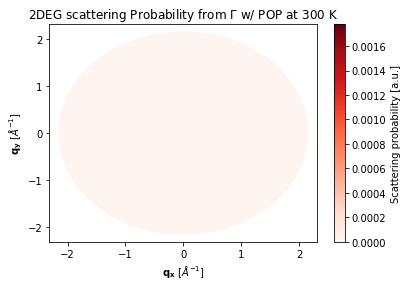

In [17]:
### Plot polar optical phonon probability
a_lat = 3.0*10**(-10)
del_t = 10**(-15)
k_pts = get_fermi_circle(2*pi/a_lat, 300, 300)
prob_POP = scatter_prob_h(np.array([0,0]), k_pts, 0.2, 300, 0,  energ_POP = .20)

cgrid = plt.cm.get_cmap('Reds')
fig4 = plt.figure()
sc = plt.scatter(to_ang*prob_POP[0], to_ang*prob_POP[1], c=prob_POP[2],vmin=0.000, vmax= np.max(prob_POP[2]), cmap=cgrid)
plt.colorbar(sc, label = 'Scattering probability [a.u.]')
plt.title("2DEG scattering Probability from $\Gamma$ w/ POP at 300 K")
plt.xlabel("$\mathbf{q_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{q_{y}} $ $[\AA^{-1}]$")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


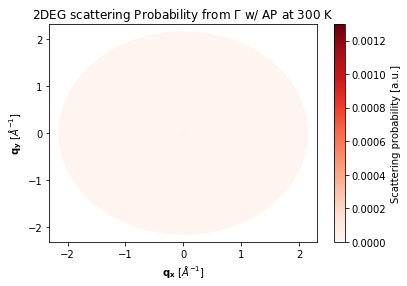

In [33]:
### Plot polar optical phonon probability
a_lat = 3.0*10**(-10)
del_t = 10**(-15)
k_pts = get_fermi_circle(2*pi/a_lat, 300, 300)
prob_AP = scatter_prob_h(np.array([0,0]), k_pts, 0.2, 300, 1,  vs = 10**5)

cgrid = plt.cm.get_cmap('Reds')
fig4 = plt.figure()
sc = plt.scatter(to_ang*prob_AP[0], to_ang*prob_AP[1], c=prob_AP[2],vmin=0.000, vmax= np.max(prob_AP[2]), cmap=cgrid)
plt.colorbar(sc, label = 'Scattering probability [a.u.]')
plt.title("2DEG scattering Probability from $\Gamma$ w/ AP at 300 K")
plt.xlabel("$\mathbf{q_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{q_{y}} $ $[\AA^{-1}]$")
plt.show()

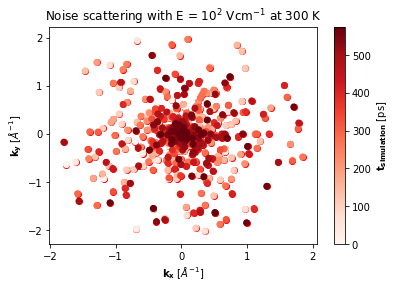

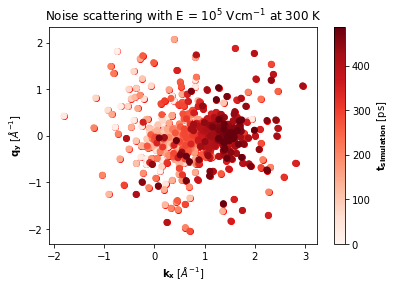

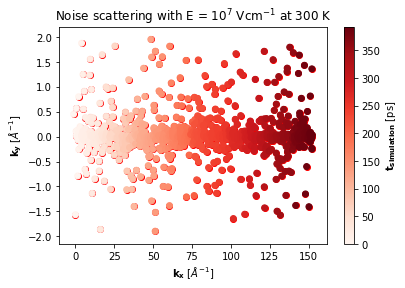

In [81]:
## Field depenent scatttering when acoustic phonon scattering is dominant 
##Run MC under various bias conditions 
del_t = 10**(-15)
k_pts = get_fermi_circle(2*pi/a_lat, 100, 100)
E_field = [np.array([10**4, 0]), np.array([10**7, 0]),np.array([10**9, 0])]
#klist_0 = run_MC(k_pts, 0.2, 300, 1, E_field[0], del_t, 10**(-12))
#klist_1 = run_MC(k_pts, 0.2, 300, 1, E_field[1], del_t, 10**(-12))
#klist_2 = run_MC(k_pts, 0.2, 300, 1, E_field[2], del_t, 10**(-12))


#Plot MC simulations under differnet bias conditions
fig = plt.figure()
plt.scatter(to_ang*klist_0[1][0],to_ang*klist_0[1][1],c="r")
sc = plt.scatter(to_ang*klist_0[1][0], to_ang*klist_0[1][1], c=klist_0[0]*(10**(12)),vmin=0, vmax=np.max(klist_0[0]*(10**(12))), cmap=cgrid)
plt.colorbar(sc, label = '$\mathbf{t_{simulation}}$ [ps]')
plt.title("Noise scattering with E = 10$^{2}$ Vcm$^{-1}$ at 300 K")
plt.xlabel("$\mathbf{k_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{k_{y}} $ $[\AA^{-1}]$")
plt.show()


fig = plt.figure()
plt.scatter(to_ang*klist_1[1][0],to_ang*klist_1[1][1],c="r")
sc = plt.scatter(to_ang*klist_1[1][0], to_ang*klist_1[1][1], c=klist_1[0]*(10**(12)),vmin=0, vmax=np.max(klist_1[0]*(10**(12))), cmap=cgrid)
plt.colorbar(sc, label = '$\mathbf{t_{simulation}}$ [ps]')
plt.title("Noise scattering with E = 10$^{5}$ Vcm$^{-1}$ at 300 K")
plt.xlabel("$\mathbf{k_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{q_{y}} $ $[\AA^{-1}]$")
plt.show()

fig = plt.figure()
plt.scatter(to_ang*klist_2[1][0],to_ang*klist_2[1][1],c="r")
sc = plt.scatter(to_ang*klist_2[1][0], to_ang*klist_2[1][1], c=klist_2[0]*(10**(12)),vmin=0, vmax=np.max(klist_2[0]*(10**(12))), cmap=cgrid)
plt.colorbar(sc, label = '$\mathbf{t_{simulation}}$ [ps]')
plt.title("Noise scattering with E = 10$^{7}$ Vcm$^{-1}$ at 300 K")
plt.xlabel("$\mathbf{k_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{k_{y}} $ $[\AA^{-1}]$")
plt.show()


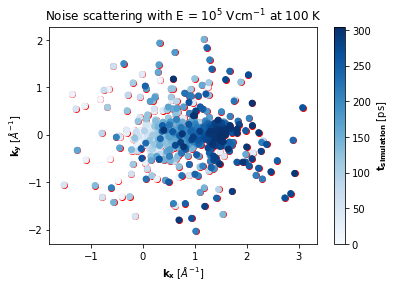

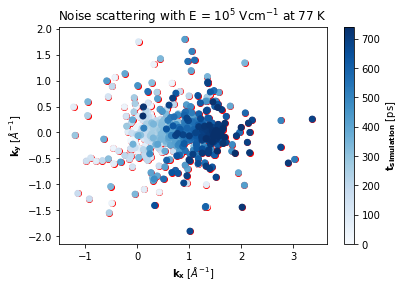

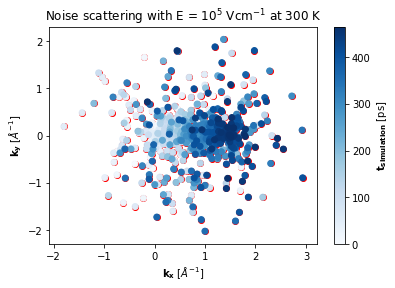

In [141]:
## Temperature depenent scatttering when acoustic phonon scattering is dominant at E = 10^2 V/cm
##Run MC under various bias conditions 

del_t = 10**(-15)
k_pts = get_fermi_circle(2*pi/a_lat, 100, 100)
E_field = np.array([10**7, 0]) 

## 4 Kelvin is really 100 K 
#klist_4 = run_MC(k_pts, 0.2, 100, 1, E_field, del_t, 10**(-12))
#klist_77 = run_MC(k_pts, 0.2, 77, 1, E_field, del_t, 10**(-12))
#klist_300 = run_MC(k_pts, 0.2, 300, 1, E_field, del_t, 10**(-12))


cgrid = plt.cm.get_cmap('Blues')
#Plot MC simulations at differnet temperatures
fig = plt.figure()
plt.scatter(to_ang*klist_4[1][0],to_ang*klist_4[1][1],c="r")
sc = plt.scatter(to_ang*klist_4[1][0], to_ang*klist_4[1][1], c=klist_4[0]*(10**(12)),vmin=0, vmax=np.max(klist_4[0]*(10**(12))), cmap=cgrid)
plt.colorbar(sc, label = '$\mathbf{t_{simulation}}$ [ps]')
plt.title("Noise scattering with E = 10$^{5}$ Vcm$^{-1}$ at 100 K")
plt.xlabel("$\mathbf{k_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{k_{y}} $ $[\AA^{-1}]$")
plt.show()



fig = plt.figure()
plt.scatter(to_ang*klist_77[1][0],to_ang*klist_77[1][1],c="r")
sc = plt.scatter(to_ang*klist_77[1][0], to_ang*klist_77[1][1], c=klist_77[0]*(10**(12)),vmin=0, vmax=np.max(klist_77[0]*(10**(12))), cmap=cgrid)
plt.colorbar(sc, label = '$\mathbf{t_{simulation}}$ [ps]')
plt.title("Noise scattering with E = 10$^{5}$ Vcm$^{-1}$ at 77 K")
plt.xlabel("$\mathbf{k_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{k_{y}} $ $[\AA^{-1}]$")
plt.show()

fig = plt.figure()
plt.scatter(to_ang*klist_300[1][0],to_ang*klist_300[1][1],c="r")
sc = plt.scatter(to_ang*klist_300[1][0], to_ang*klist_300[1][1], c=klist_300[0]*(10**(12)),vmin=0, vmax=np.max(klist_300[0]*(10**(12))), cmap=cgrid)
plt.colorbar(sc, label = '$\mathbf{t_{simulation}}$ [ps]')
plt.title("Noise scattering with E = 10$^{5}$ Vcm$^{-1}$ at 300 K")
plt.xlabel("$\mathbf{k_{x}}$ $[\AA^{-1}]$")
plt.ylabel("$\mathbf{k_{y}} $ $[\AA^{-1}]$")
plt.show()

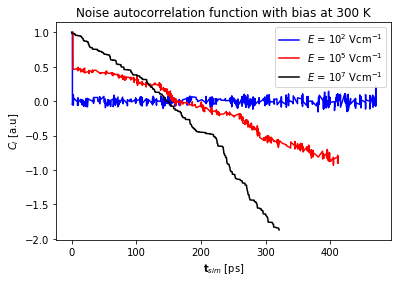

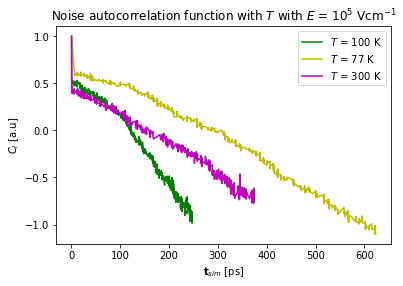

In [135]:
# Plot autocorrelation funcitons under different fields 
v_0 = get_velocities(klist_0 , 0.2)
v_1 = get_velocities(klist_1, 0.2)
v_2 = get_velocities(klist_2, 0.2)
C_0 = estimated_autocorrelation(v_0[1])
C_1 = estimated_autocorrelation(v_1[1])
C_2 = estimated_autocorrelation(v_2[1])

# Plot autocorrelation funcitons at different temperatures
v_4 = get_velocities(klist_4 , 0.2)
v_77 = get_velocities(klist_77, 0.2)
v_300 = get_velocities(klist_300, 0.2)

C_4 = estimated_autocorrelation(v_4[1])
C_77 = estimated_autocorrelation(v_77[1])
C_300 = estimated_autocorrelation(v_300[1])


fig = plt.figure()
plt.plot(klist_0[0][0:800]*(10**(12)), C_0[0:800], label='$E$ = 10$^{2}$ Vcm$^{-1}$', c = "b")
plt.plot(klist_1[0][0:800]*(10**(12)), C_1[0:800], label='$E$ = 10$^{5}$ Vcm$^{-1}$',c = "r")
plt.plot(klist_2[0][0:800]*(10**(12)), C_2[0:800], label='$E$ = 10$^{7}$ Vcm$^{-1}$',c = "k")
plt.legend()
plt.title("Noise autocorrelation function with bias at 300 K")
plt.xlabel("$\mathbf{t}_{sim}$ [ps]")
plt.ylabel("$C_{I}$ [a.u]")
plt.show()



fig = plt.figure()
plt.plot(klist_4[0][0:800]*(10**(12)), C_4[0:800], label='$T$ = 100 K', c = "g")
plt.plot(klist_77[0][0:800]*(10**(12)), C_77[0:800], label='$T$ = 77 K ',c = "y")
plt.plot(klist_300[0][0:800]*(10**(12)), C_300[0:800], label='$T$ = 300 K',c = "m")
plt.legend()
plt.title("Noise autocorrelation function with $T$ with $E$ = 10$^{5}$ Vcm$^{-1}$")
plt.xlabel("$\mathbf{t}_{sim}$ [ps]")
plt.ylabel("$C_{I}$ [a.u]")
plt.show()

In [128]:
##Get noise spectra 
S_0 = get_power_spectrum(v_0[1])
S_1 = get_power_spectrum(v_1[1])
S_2 = get_power_spectrum(v_2[1])


S_4 = get_power_spectrum(v_4[1])
S_77 = get_power_spectrum(v_77[1])
S_300 = get_power_spectrum(v_300[1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:200: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


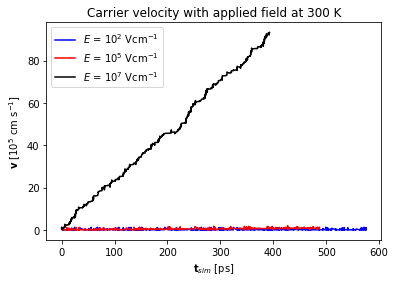

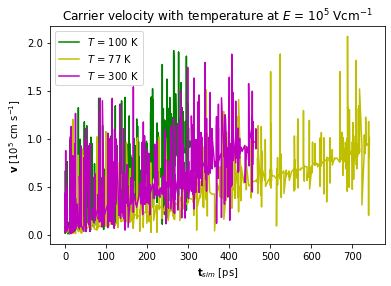

In [140]:
## Plot velocities 
v_0 = get_velocities(klist_0 , 0.2)
v_1 = get_velocities(klist_1, 0.2)
v_2 = get_velocities(klist_2, 0.2)

v_4 = get_velocities(klist_4 , 0.2)
v_77 = get_velocities(klist_77, 0.2)
v_300 = get_velocities(klist_300, 0.2)

fig = plt.figure()
plt.plot(v_0[0]*(10**(12)), v_0[1]*(10**(-5)), label='$E$ = 10$^{2}$ Vcm$^{-1}$', c = "b")
plt.plot(v_1[0]*(10**(12)), v_1[1]*(10**(-5)), label='$E$ = 10$^{5}$ Vcm$^{-1}$' ,c = "r")
plt.plot(v_2[0]*(10**(12)), v_2[1]*(10**(-5)), label='$E$ = 10$^{7}$ Vcm$^{-1}$',c = "k")
plt.legend()
plt.title("Carrier velocity with applied field at 300 K")
plt.xlabel("$\mathbf{t}_{sim}$ [ps]")
plt.ylabel("$\mathbf{v}$ [$10^{5}$ cm s$^{-1}$]")
plt.show()


fig = plt.figure()
plt.plot(v_4[0]*(10**(12)), v_4[1]*(10**(-5)), label='$T$ = 100 K', c = "g")
plt.plot(v_77[0]*(10**(12)), v_77[1]*(10**(-5)), label='$T$ = 77 K' ,c = "y")
plt.plot(v_300[0]*(10**(12)), v_300[1]*(10**(-5)), label='$T$ = 300 K',c = "m")
plt.legend()
plt.title("Carrier velocity with temperature at $E$ = 10$^{5}$ Vcm$^{-1}$")
plt.xlabel("$\mathbf{t}_{sim}$ [ps]")
plt.ylabel("$\mathbf{v}$ [$10^{5}$ cm s$^{-1}$]")
plt.show()

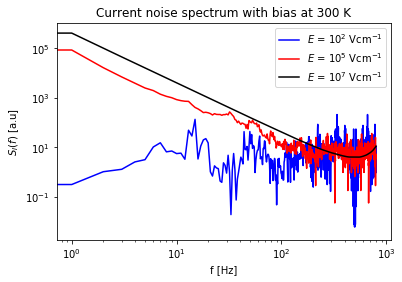

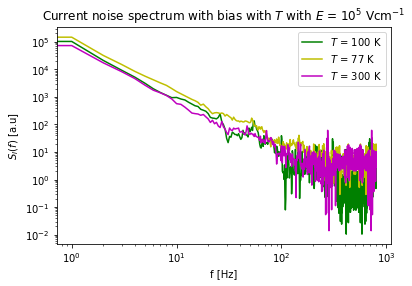

In [137]:
## Plot power spectra 
fig = plt.figure()
plt.loglog(S_0[0:800], label='$E$ = 10$^{2}$ Vcm$^{-1}$', c = "b")
plt.loglog(S_1[0:800], label='$E$ = 10$^{5}$ Vcm$^{-1}$',c = "r")
plt.loglog(S_2[0:800], label='$E$ = 10$^{7}$ Vcm$^{-1}$',c = "k")
plt.legend()
plt.title("Current noise spectrum with bias at 300 K")
plt.xlabel("f [Hz]")
plt.ylabel("$S_{I}(f)$ [a.u]")
plt.show()


fig = plt.figure()
plt.loglog(S_4[0:800], label='$T$ = 100 K', c = "g")
plt.loglog(S_77[0:800], label='$T$ = 77 K',c = "y")
plt.loglog(S_300[0:800], label='$T$ = 300 K',c = "m")
plt.legend()
plt.title("Current noise spectrum with bias with $T$ with $E$ = 10$^{5}$ Vcm$^{-1}$")
plt.xlabel("f [Hz]")
plt.ylabel("$S_{I}(f)$ [a.u]")
plt.show()